### Install Tensorflow 2 and some other libraries

In [68]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from yahoo_fin import stock_info as si
from collections import deque

import os
import numpy as np
import pandas as pd
import random


In [69]:
# set seed, so we can get the same results after rerunning several times
np.random.seed(314)
random.seed(314)

In [70]:
import os
import time
from tensorflow.keras.layers import LSTM

# Window size or the sequence length
N_STEPS = 50
# Lookup step, 1 is the next day
LOOKUP_STEP = 15

# whether to scale feature columns & output price as well
SCALE = True
scale_str = f"sc-{int(SCALE)}"
# whether to shuffle the dataset
SHUFFLE = True
shuffle_str = f"sh-{int(SHUFFLE)}"
# whether to split the training/testing set by date
SPLIT_BY_DATE = False
split_by_date_str = f"sbd-{int(SPLIT_BY_DATE)}"
# test ratio size, 0.2 is 20%
TEST_SIZE = 0.2
# features to use
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]
# date now
date_now = time.strftime("%Y-%m-%d")

### model parameters

N_LAYERS = 2
# LSTM cell
CELL = LSTM
# 256 LSTM neurons
UNITS = 256
# 40% dropout
DROPOUT = 0.4
# whether to use bidirectional RNNs
BIDIRECTIONAL = False

### training parameters

# mean absolute error loss
# LOSS = "mae"
# huber loss
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 64
EPOCHS = 500

# SPDR Gold Shares (GLD)
ticker = "GLD"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")
# model name to save, making it as unique as possible based on parameters
model_name = f"{date_now}_{ticker}-{shuffle_str}-{scale_str}-{split_by_date_str}-\
{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"

### Preparing the Dataset
we need to write a function that downloads the dataset from the Internet and preprocess it:

In [71]:
def shuffle_in_unison(a, b):
    # shuffle two arrays in the same way
    state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(state)
    np.random.shuffle(b)


def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, split_by_date=True,
                test_size=0.2, feature_columns=['adjclose', 'volume', 'open', 'high', 'low']):
    """
    Loads data from Yahoo Finance source, as well as scaling, shuffling, normalizing and splitting.
    Params:
        ticker (str/pd.DataFrame): the ticker you want to load, examples include AAPL, TESL, etc.
        n_steps (int): the historical sequence length (i.e window size) used to predict, default is 50
        scale (bool): whether to scale prices from 0 to 1, default is True
        shuffle (bool): whether to shuffle the dataset (both training & testing), default is True
        lookup_step (int): the future lookup step to predict, default is 1 (e.g next day)
        split_by_date (bool): whether we split the dataset into training/testing by date, setting it 
            to False will split datasets in a random way
        test_size (float): ratio for test data, default is 0.2 (20% testing data)
        feature_columns (list): the list of features to use to feed into the model, default is everything grabbed from yahoo_fin
    """
    # see if ticker is already a loaded stock from yahoo finance
    if isinstance(ticker, str):
        # load it from yahoo_fin library
        df = si.get_data(ticker)
    elif isinstance(ticker, pd.DataFrame):
        # already loaded, use it directly
        df = ticker
    else:
        raise TypeError("ticker can be either a str or a `pd.DataFrame` instances")

    # this will contain all the elements we want to return from this function
    result = {}
    # we will also return the original dataframe itself
    result['df'] = df.copy()

    # make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."

    # add date as a column
    if "date" not in df.columns:
        df["date"] = df.index

    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler

        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler

    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['adjclose'].shift(-lookup_step)

    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    
    # drop NaNs
    df.dropna(inplace=True)

    sequence_data = []
    sequences = deque(maxlen=n_steps)

    for entry, target in zip(df[feature_columns + ["date"]].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])

    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 60 (that is 50+10) length
    # this last_sequence will be used to predict future stock prices that are not available in the dataset
    last_sequence = list([s[:len(feature_columns)] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)
    # add to result
    result['last_sequence'] = last_sequence
    
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)

    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)

    if split_by_date:
        # split the dataset into training & testing sets by date (not randomly splitting)
        train_samples = int((1 - test_size) * len(X))
        result["X_train"] = X[:train_samples]
        result["y_train"] = y[:train_samples]
        result["X_test"]  = X[train_samples:]
        result["y_test"]  = y[train_samples:]
        if shuffle:
            # shuffle the datasets for training (if shuffle parameter is set)
            shuffle_in_unison(result["X_train"], result["y_train"])
            shuffle_in_unison(result["X_test"], result["y_test"])
    else:    
        # split the dataset randomly
        result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, 
                                                                                test_size=test_size, shuffle=shuffle)

    # get the list of test set dates
    dates = result["X_test"][:, -1, -1]
    # retrieve test features from the original dataframe
    result["test_df"] = result["df"].loc[dates]
    # remove duplicated dates in the testing dataframe
    result["test_df"] = result["test_df"][~result["test_df"].index.duplicated(keep='first')]
    # remove dates from the training/testing sets & convert to float32
    result["X_train"] = result["X_train"][:, :, :len(feature_columns)].astype(np.float32)
    result["X_test"] = result["X_test"][:, :, :len(feature_columns)].astype(np.float32)

    return result

### Model Creation
Now that we have a proper function to load and prepare the dataset, we need another core function to build our model:

In [72]:
def create_model(sequence_length, n_features, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), batch_input_shape=(None, sequence_length, n_features)))
            else:
                model.add(cell(units, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

In [73]:
# create these folders if they does not exist
if not os.path.isdir("results"):
    os.mkdir("results")

if not os.path.isdir("logs"):
    os.mkdir("logs")

if not os.path.isdir("data"):
    os.mkdir("data")

# load the data
data = load_data(ticker, N_STEPS, scale=SCALE, split_by_date=SPLIT_BY_DATE, 
                shuffle=SHUFFLE, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, 
                feature_columns=FEATURE_COLUMNS)

# save the dataframe
data["df"].to_csv(ticker_data_filename)

# construct the model
model = create_model(N_STEPS, len(FEATURE_COLUMNS), loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)

### Training the Model
Now that we have all the core functions ready, let's train our model

In [74]:
# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
# train the model and save the weights whenever we see 
# a new optimal model using ModelCheckpoint
history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)

Train on 3420 samples, validate on 855 samples
Epoch 1/500
3392/3420 [============================>.] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0860- ETA: 3s - loss: 0.0152 - mea - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.08
Epoch 00001: val_loss improved from inf to 0.00075, saving model to results\2022-02-13_GLD-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5
3420/3420 [==============================] - 7s 2ms/sample - loss: 0.0087 - mean_absolute_error: 0.0857 - val_loss: 7.4748e-04 - val_mean_absolute_error: 0.0290
Epoch 2/500
3392/3420 [============================>.] - ETA: 0s - loss: 0.0013 - mean_absolute_error: 0.0387- ETA: 4s -
Epoch 00002: val_loss improved from 0.00075 to 0.00071, saving model to results\2022-02-13_GLD-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5
3420/3420 [==============================] - 6s 2ms/sample - loss: 0.0013 - mean_absolute_error: 0.0386 - val_loss: 7.1183e-04 - val_mean_absolu

Epoch 21/500
3392/3420 [============================>.] - ETA: 0s - loss: 0.0011 - mean_absolute_error: 0.0354
Epoch 00021: val_loss improved from 0.00062 to 0.00061, saving model to results\2022-02-13_GLD-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5
3420/3420 [==============================] - 6s 2ms/sample - loss: 0.0011 - mean_absolute_error: 0.0354 - val_loss: 6.1168e-04 - val_mean_absolute_error: 0.0258
Epoch 22/500
3392/3420 [============================>.] - ETA: 0s - loss: 0.0011 - mean_absolute_error: 0.0351- ETA: 3s - loss: 
Epoch 00022: val_loss did not improve from 0.00061
3420/3420 [==============================] - 6s 2ms/sample - loss: 0.0011 - mean_absolute_error: 0.0351 - val_loss: 0.0011 - val_mean_absolute_error: 0.0357
Epoch 23/500
3392/3420 [============================>.] - ETA: 0s - loss: 0.0012 - mean_absolute_error: 0.0369
Epoch 00023: val_loss did not improve from 0.00061
3420/3420 [==============================] - 6s 2ms/sample -

Epoch 42/500
3392/3420 [============================>.] - ETA: 0s - loss: 9.0370e-04 - mean_absolute_error: 0.0321- ETA: 4s - loss: 8.5654e-04 - mean_absolute_err - ETA: 3s - loss: 8.28
Epoch 00042: val_loss did not improve from 0.00060
3420/3420 [==============================] - 6s 2ms/sample - loss: 9.0285e-04 - mean_absolute_error: 0.0321 - val_loss: 8.8297e-04 - val_mean_absolute_error: 0.0320
Epoch 43/500
3392/3420 [============================>.] - ETA: 0s - loss: 8.7595e-04 - mean_absolute_error: 0.0317
Epoch 00043: val_loss did not improve from 0.00060
3420/3420 [==============================] - 6s 2ms/sample - loss: 8.7653e-04 - mean_absolute_error: 0.0317 - val_loss: 5.9927e-04 - val_mean_absolute_error: 0.0255
Epoch 44/500
3392/3420 [============================>.] - ETA: 0s - loss: 9.0013e-04 - mean_absolute_error: 0.0321
Epoch 00044: val_loss improved from 0.00060 to 0.00060, saving model to results\2022-02-13_GLD-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layer

Epoch 64/500
3392/3420 [============================>.] - ETA: 0s - loss: 8.0205e-04 - mean_absolute_error: 0.0305
Epoch 00064: val_loss improved from 0.00060 to 0.00059, saving model to results\2022-02-13_GLD-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5
3420/3420 [==============================] - 6s 2ms/sample - loss: 8.0357e-04 - mean_absolute_error: 0.0305 - val_loss: 5.8703e-04 - val_mean_absolute_error: 0.0253
Epoch 65/500
3392/3420 [============================>.] - ETA: 0s - loss: 8.3743e-04 - mean_absolute_error: 0.0308
Epoch 00065: val_loss did not improve from 0.00059
3420/3420 [==============================] - 6s 2ms/sample - loss: 8.3599e-04 - mean_absolute_error: 0.0308 - val_loss: 5.9145e-04 - val_mean_absolute_error: 0.0258
Epoch 66/500
3392/3420 [============================>.] - ETA: 0s - loss: 8.2960e-04 - mean_absolute_error: 0.0308
Epoch 00066: val_loss did not improve from 0.00059
3420/3420 [==============================] - 6s 2ms/sa

3392/3420 [============================>.] - ETA: 0s - loss: 7.1582e-04 - mean_absolute_error: 0.0290
Epoch 00086: val_loss did not improve from 0.00059
3420/3420 [==============================] - 6s 2ms/sample - loss: 7.1833e-04 - mean_absolute_error: 0.0291 - val_loss: 6.2121e-04 - val_mean_absolute_error: 0.0266
Epoch 87/500
3392/3420 [============================>.] - ETA: 0s - loss: 7.2392e-04 - mean_absolute_error: 0.0290
Epoch 00087: val_loss did not improve from 0.00059
3420/3420 [==============================] - 6s 2ms/sample - loss: 7.2648e-04 - mean_absolute_error: 0.0290 - val_loss: 6.1540e-04 - val_mean_absolute_error: 0.0264
Epoch 88/500
3392/3420 [============================>.] - ETA: 0s - loss: 7.0914e-04 - mean_absolute_error: 0.0290- ETA: 1s - loss: 6.9772e-04 - mean_absolute_
Epoch 00088: val_loss did not improve from 0.00059
3420/3420 [==============================] - 6s 2ms/sample - loss: 7.0998e-04 - mean_absolute_error: 0.0290 - val_loss: 7.4932e-04 - val_mea

Epoch 109/500
3392/3420 [============================>.] - ETA: 0s - loss: 6.6506e-04 - mean_absolute_error: 0.0277
Epoch 00109: val_loss did not improve from 0.00056
3420/3420 [==============================] - 6s 2ms/sample - loss: 6.6350e-04 - mean_absolute_error: 0.0277 - val_loss: 6.3735e-04 - val_mean_absolute_error: 0.0270
Epoch 110/500
3392/3420 [============================>.] - ETA: 0s - loss: 6.7660e-04 - mean_absolute_error: 0.0280- ETA: 1s - loss: 6.5985e-04 - mean_absolute_error: 0. - ETA: 0s - loss: 6.7038e-04 - mean_absolute_error: 0.0 - ETA: 0s - loss: 6.7056e-04 - mean_absolute_error: 
Epoch 00110: val_loss improved from 0.00056 to 0.00055, saving model to results\2022-02-13_GLD-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5
3420/3420 [==============================] - 6s 2ms/sample - loss: 6.7658e-04 - mean_absolute_error: 0.0280 - val_loss: 5.4811e-04 - val_mean_absolute_error: 0.0246
Epoch 111/500
3392/3420 [============================>.

Epoch 132/500
3392/3420 [============================>.] - ETA: 0s - loss: 6.7061e-04 - mean_absolute_error: 0.0281- ETA: 1s - loss: 6.7558e-04 - mean_absolu
Epoch 00132: val_loss did not improve from 0.00053
3420/3420 [==============================] - 6s 2ms/sample - loss: 6.7064e-04 - mean_absolute_error: 0.0282 - val_loss: 5.4881e-04 - val_mean_absolute_error: 0.0247
Epoch 133/500
3392/3420 [============================>.] - ETA: 0s - loss: 6.5516e-04 - mean_absolute_error: 0.0276
Epoch 00133: val_loss did not improve from 0.00053
3420/3420 [==============================] - 6s 2ms/sample - loss: 6.5330e-04 - mean_absolute_error: 0.0276 - val_loss: 5.4197e-04 - val_mean_absolute_error: 0.0245
Epoch 134/500
3392/3420 [============================>.] - ETA: 0s - loss: 6.7534e-04 - mean_absolute_error: 0.0281- ETA: 2s - loss: 6.9042e-04 - 
Epoch 00134: val_loss did not improve from 0.00053
3420/3420 [==============================] - 6s 2ms/sample - loss: 6.7448e-04 - mean_absolute_er

Epoch 155/500
3392/3420 [============================>.] - ETA: 0s - loss: 6.7056e-04 - mean_absolute_error: 0.0283
Epoch 00155: val_loss did not improve from 0.00052
3420/3420 [==============================] - 6s 2ms/sample - loss: 6.7861e-04 - mean_absolute_error: 0.0284 - val_loss: 6.1413e-04 - val_mean_absolute_error: 0.0271
Epoch 156/500
3392/3420 [============================>.] - ETA: 0s - loss: 6.4213e-04 - mean_absolute_error: 0.0277
Epoch 00156: val_loss did not improve from 0.00052
3420/3420 [==============================] - 6s 2ms/sample - loss: 6.3908e-04 - mean_absolute_error: 0.0276 - val_loss: 5.3302e-04 - val_mean_absolute_error: 0.0251
Epoch 157/500
3392/3420 [============================>.] - ETA: 0s - loss: 6.2307e-04 - mean_absolute_error: 0.0273
Epoch 00157: val_loss did not improve from 0.00052
3420/3420 [==============================] - 6s 2ms/sample - loss: 6.2301e-04 - mean_absolute_error: 0.0274 - val_loss: 5.2446e-04 - val_mean_absolute_error: 0.0245
Epoc

Epoch 178/500
3392/3420 [============================>.] - ETA: 0s - loss: 6.0205e-04 - mean_absolute_error: 0.0267- ETA: 0s - loss: 6.0262e-04 - mean_absolute_error: 0.02
Epoch 00178: val_loss did not improve from 0.00048
3420/3420 [==============================] - 6s 2ms/sample - loss: 6.0562e-04 - mean_absolute_error: 0.0268 - val_loss: 5.4088e-04 - val_mean_absolute_error: 0.0253
Epoch 179/500
3392/3420 [============================>.] - ETA: 0s - loss: 6.2829e-04 - mean_absolute_error: 0.0274- ETA: 2s - loss: 6.3591e-04 - m
Epoch 00179: val_loss did not improve from 0.00048
3420/3420 [==============================] - 6s 2ms/sample - loss: 6.2815e-04 - mean_absolute_error: 0.0274 - val_loss: 5.7008e-04 - val_mean_absolute_error: 0.0258
Epoch 180/500
3392/3420 [============================>.] - ETA: 0s - loss: 6.1442e-04 - mean_absolute_error: 0.0270- ETA: 4s - l
Epoch 00180: val_loss improved from 0.00048 to 0.00048, saving model to results\2022-02-13_GLD-sh-1-sc-1-sbd-0-huber_lo

Epoch 201/500
3392/3420 [============================>.] - ETA: 0s - loss: 5.9085e-04 - mean_absolute_error: 0.0266
Epoch 00201: val_loss improved from 0.00047 to 0.00047, saving model to results\2022-02-13_GLD-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5
3420/3420 [==============================] - 6s 2ms/sample - loss: 5.8993e-04 - mean_absolute_error: 0.0266 - val_loss: 4.6812e-04 - val_mean_absolute_error: 0.0235
Epoch 202/500
3392/3420 [============================>.] - ETA: 0s - loss: 5.9876e-04 - mean_absolute_error: 0.0269
Epoch 00202: val_loss did not improve from 0.00047
3420/3420 [==============================] - 6s 2ms/sample - loss: 5.9931e-04 - mean_absolute_error: 0.0269 - val_loss: 4.7396e-04 - val_mean_absolute_error: 0.0237
Epoch 203/500
3392/3420 [============================>.] - ETA: 0s - loss: 6.0326e-04 - mean_absolute_error: 0.0268
Epoch 00203: val_loss did not improve from 0.00047
3420/3420 [==============================] - 6s 2ms

Epoch 223/500
3392/3420 [============================>.] - ETA: 0s - loss: 5.6058e-04 - mean_absolute_error: 0.0259
Epoch 00223: val_loss did not improve from 0.00045
3420/3420 [==============================] - 6s 2ms/sample - loss: 5.6328e-04 - mean_absolute_error: 0.0260 - val_loss: 5.0521e-04 - val_mean_absolute_error: 0.0242
Epoch 224/500
3392/3420 [============================>.] - ETA: 0s - loss: 5.7082e-04 - mean_absolute_error: 0.0261
Epoch 00224: val_loss did not improve from 0.00045
3420/3420 [==============================] - 6s 2ms/sample - loss: 5.6978e-04 - mean_absolute_error: 0.0261 - val_loss: 4.5249e-04 - val_mean_absolute_error: 0.0228
Epoch 225/500
3392/3420 [============================>.] - ETA: 0s - loss: 5.9012e-04 - mean_absolute_error: 0.0266
Epoch 00225: val_loss did not improve from 0.00045
3420/3420 [==============================] - 6s 2ms/sample - loss: 5.8932e-04 - mean_absolute_error: 0.0266 - val_loss: 4.6371e-04 - val_mean_absolute_error: 0.0231
Epoc

Epoch 246/500
3392/3420 [============================>.] - ETA: 0s - loss: 5.4989e-04 - mean_absolute_error: 0.0257
Epoch 00246: val_loss improved from 0.00043 to 0.00043, saving model to results\2022-02-13_GLD-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5
3420/3420 [==============================] - 6s 2ms/sample - loss: 5.4989e-04 - mean_absolute_error: 0.0257 - val_loss: 4.2763e-04 - val_mean_absolute_error: 0.0225
Epoch 247/500
3392/3420 [============================>.] - ETA: 0s - loss: 5.4888e-04 - mean_absolute_error: 0.0255
Epoch 00247: val_loss did not improve from 0.00043
3420/3420 [==============================] - 6s 2ms/sample - loss: 5.5096e-04 - mean_absolute_error: 0.0255 - val_loss: 4.3445e-04 - val_mean_absolute_error: 0.0224
Epoch 248/500
3392/3420 [============================>.] - ETA: 0s - loss: 5.5316e-04 - mean_absolute_error: 0.0258
Epoch 00248: val_loss improved from 0.00043 to 0.00042, saving model to results\2022-02-13_GLD-sh-1-sc

3392/3420 [============================>.] - ETA: 0s - loss: 5.3572e-04 - mean_absolute_error: 0.0253
Epoch 00268: val_loss did not improve from 0.00041
3420/3420 [==============================] - 6s 2ms/sample - loss: 5.3498e-04 - mean_absolute_error: 0.0253 - val_loss: 4.3475e-04 - val_mean_absolute_error: 0.0226
Epoch 269/500
3392/3420 [============================>.] - ETA: 0s - loss: 5.4597e-04 - mean_absolute_error: 0.0254
Epoch 00269: val_loss improved from 0.00041 to 0.00040, saving model to results\2022-02-13_GLD-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5
3420/3420 [==============================] - 6s 2ms/sample - loss: 5.4774e-04 - mean_absolute_error: 0.0255 - val_loss: 4.0372e-04 - val_mean_absolute_error: 0.0221
Epoch 270/500
3392/3420 [============================>.] - ETA: 0s - loss: 5.3266e-04 - mean_absolute_error: 0.0253- ETA: 0s - loss: 5.3071e-04 - mean_absolute_error: 0.025
Epoch 00270: val_loss did not improve from 0.00040
3420/342

Epoch 291/500
3392/3420 [============================>.] - ETA: 0s - loss: 5.2318e-04 - mean_absolute_error: 0.0251
Epoch 00291: val_loss did not improve from 0.00039
3420/3420 [==============================] - 6s 2ms/sample - loss: 5.2246e-04 - mean_absolute_error: 0.0251 - val_loss: 4.1993e-04 - val_mean_absolute_error: 0.0226
Epoch 292/500
3392/3420 [============================>.] - ETA: 0s - loss: 5.1215e-04 - mean_absolute_error: 0.0249- ETA: 1s - loss: 5.1254e-04 - mean_absolute_
Epoch 00292: val_loss did not improve from 0.00039
3420/3420 [==============================] - 6s 2ms/sample - loss: 5.1455e-04 - mean_absolute_error: 0.0250 - val_loss: 4.1754e-04 - val_mean_absolute_error: 0.0224
Epoch 293/500
3392/3420 [============================>.] - ETA: 0s - loss: 5.0456e-04 - mean_absolute_error: 0.0246- ETA: 3s - loss: 4.9191e
Epoch 00293: val_loss improved from 0.00039 to 0.00039, saving model to results\2022-02-13_GLD-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-lay

Epoch 314/500
3392/3420 [============================>.] - ETA: 0s - loss: 5.1373e-04 - mean_absolute_error: 0.0248
Epoch 00314: val_loss did not improve from 0.00037
3420/3420 [==============================] - 6s 2ms/sample - loss: 5.1360e-04 - mean_absolute_error: 0.0249 - val_loss: 3.8114e-04 - val_mean_absolute_error: 0.0215
Epoch 315/500
3392/3420 [============================>.] - ETA: 0s - loss: 4.9171e-04 - mean_absolute_error: 0.0244
Epoch 00315: val_loss did not improve from 0.00037
3420/3420 [==============================] - 6s 2ms/sample - loss: 4.8999e-04 - mean_absolute_error: 0.0243 - val_loss: 4.1769e-04 - val_mean_absolute_error: 0.0221
Epoch 316/500
3392/3420 [============================>.] - ETA: 0s - loss: 4.9857e-04 - mean_absolute_error: 0.0245
Epoch 00316: val_loss did not improve from 0.00037
3420/3420 [==============================] - 6s 2ms/sample - loss: 4.9815e-04 - mean_absolute_error: 0.0245 - val_loss: 4.4706e-04 - val_mean_absolute_error: 0.0233
Epoc

Epoch 337/500
3392/3420 [============================>.] - ETA: 0s - loss: 4.9313e-04 - mean_absolute_error: 0.0246- ETA: 3s - loss: 4.7871e-04 - mean_abs - ETA: 1s - loss: 4.8779e-04 - mean_absolute_
Epoch 00337: val_loss did not improve from 0.00037
3420/3420 [==============================] - 6s 2ms/sample - loss: 4.9173e-04 - mean_absolute_error: 0.0245 - val_loss: 4.4367e-04 - val_mean_absolute_error: 0.0223
Epoch 338/500
3392/3420 [============================>.] - ETA: 0s - loss: 4.9948e-04 - mean_absolute_error: 0.0246
Epoch 00338: val_loss improved from 0.00037 to 0.00036, saving model to results\2022-02-13_GLD-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5
3420/3420 [==============================] - 6s 2ms/sample - loss: 4.9986e-04 - mean_absolute_error: 0.0246 - val_loss: 3.6119e-04 - val_mean_absolute_error: 0.0209
Epoch 339/500
3392/3420 [============================>.] - ETA: 0s - loss: 4.6721e-04 - mean_absolute_error: 0.0238- ETA: 2s - loss: 

Epoch 359/500
3392/3420 [============================>.] - ETA: 0s - loss: 4.8689e-04 - mean_absolute_error: 0.0243- ETA: 0s - loss: 4.8811e-04 - mean_absolute_error: 0.02
Epoch 00359: val_loss did not improve from 0.00035
3420/3420 [==============================] - 6s 2ms/sample - loss: 4.8491e-04 - mean_absolute_error: 0.0243 - val_loss: 3.6534e-04 - val_mean_absolute_error: 0.0212
Epoch 360/500
3392/3420 [============================>.] - ETA: 0s - loss: 4.6302e-04 - mean_absolute_error: 0.0239
Epoch 00360: val_loss did not improve from 0.00035
3420/3420 [==============================] - 6s 2ms/sample - loss: 4.6350e-04 - mean_absolute_error: 0.0239 - val_loss: 4.2112e-04 - val_mean_absolute_error: 0.0228
Epoch 361/500
3392/3420 [============================>.] - ETA: 0s - loss: 4.7370e-04 - mean_absolute_error: 0.0239- ETA: 0s - loss: 4.7309e-04 - mean_absolute_erro
Epoch 00361: val_loss did not improve from 0.00035
3420/3420 [==============================] - 6s 2ms/sample - los

Epoch 381/500
3392/3420 [============================>.] - ETA: 0s - loss: 4.4602e-04 - mean_absolute_error: 0.0231
Epoch 00381: val_loss did not improve from 0.00032
3420/3420 [==============================] - 6s 2ms/sample - loss: 4.4583e-04 - mean_absolute_error: 0.0231 - val_loss: 3.3934e-04 - val_mean_absolute_error: 0.0201
Epoch 382/500
3392/3420 [============================>.] - ETA: 0s - loss: 4.2971e-04 - mean_absolute_error: 0.0229- ETA: 0s - loss: 4.2832e-04 - mean_absolute_error
Epoch 00382: val_loss did not improve from 0.00032
3420/3420 [==============================] - 6s 2ms/sample - loss: 4.2981e-04 - mean_absolute_error: 0.0229 - val_loss: 3.4393e-04 - val_mean_absolute_error: 0.0206
Epoch 383/500
3392/3420 [============================>.] - ETA: 0s - loss: 4.3492e-04 - mean_absolute_error: 0.0230
Epoch 00383: val_loss did not improve from 0.00032
3420/3420 [==============================] - 6s 2ms/sample - loss: 4.3284e-04 - mean_absolute_error: 0.0229 - val_loss:

3392/3420 [============================>.] - ETA: 0s - loss: 4.0830e-04 - mean_absolute_error: 0.0222- ETA: 3s - loss: 4.4070e-
Epoch 00403: val_loss did not improve from 0.00030
3420/3420 [==============================] - 6s 2ms/sample - loss: 4.0783e-04 - mean_absolute_error: 0.0222 - val_loss: 3.2605e-04 - val_mean_absolute_error: 0.0200
Epoch 404/500
3392/3420 [============================>.] - ETA: 0s - loss: 4.2244e-04 - mean_absolute_error: 0.0226
Epoch 00404: val_loss did not improve from 0.00030
3420/3420 [==============================] - 6s 2ms/sample - loss: 4.2085e-04 - mean_absolute_error: 0.0226 - val_loss: 3.0677e-04 - val_mean_absolute_error: 0.0193
Epoch 405/500
3392/3420 [============================>.] - ETA: 0s - loss: 3.9832e-04 - mean_absolute_error: 0.0220- ETA: 3s - loss: 4.0941e-04 - ETA: 0s - loss: 3.9981e-04 - mean_absolute_error: 0
Epoch 00405: val_loss did not improve from 0.00030
3420/3420 [==============================] - 6s 2ms/sample - loss: 3.9835e-

3392/3420 [============================>.] - ETA: 0s - loss: 3.8011e-04 - mean_absolute_error: 0.0214
Epoch 00425: val_loss did not improve from 0.00028
3420/3420 [==============================] - 6s 2ms/sample - loss: 3.7952e-04 - mean_absolute_error: 0.0214 - val_loss: 2.9771e-04 - val_mean_absolute_error: 0.0192
Epoch 426/500
3392/3420 [============================>.] - ETA: 0s - loss: 3.9104e-04 - mean_absolute_error: 0.0219
Epoch 00426: val_loss did not improve from 0.00028
3420/3420 [==============================] - 6s 2ms/sample - loss: 3.9189e-04 - mean_absolute_error: 0.0219 - val_loss: 3.1100e-04 - val_mean_absolute_error: 0.0195
Epoch 427/500
3392/3420 [============================>.] - ETA: 0s - loss: 3.9235e-04 - mean_absolute_error: 0.0219
Epoch 00427: val_loss improved from 0.00028 to 0.00027, saving model to results\2022-02-13_GLD-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5
3420/3420 [==============================] - 6s 2ms/sample - loss

Epoch 449/500
3392/3420 [============================>.] - ETA: 0s - loss: 3.7729e-04 - mean_absolute_error: 0.0215
Epoch 00449: val_loss did not improve from 0.00026
3420/3420 [==============================] - 6s 2ms/sample - loss: 3.7891e-04 - mean_absolute_error: 0.0216 - val_loss: 3.0485e-04 - val_mean_absolute_error: 0.0191
Epoch 450/500
3392/3420 [============================>.] - ETA: 0s - loss: 3.7613e-04 - mean_absolute_error: 0.0214
Epoch 00450: val_loss did not improve from 0.00026
3420/3420 [==============================] - 6s 2ms/sample - loss: 3.7690e-04 - mean_absolute_error: 0.0215 - val_loss: 3.0163e-04 - val_mean_absolute_error: 0.0193
Epoch 451/500
3392/3420 [============================>.] - ETA: 0s - loss: 3.7700e-04 - mean_absolute_error: 0.0215- ETA: 4s - los
Epoch 00451: val_loss did not improve from 0.00026
3420/3420 [==============================] - 6s 2ms/sample - loss: 3.7669e-04 - mean_absolute_error: 0.0215 - val_loss: 2.7233e-04 - val_mean_absolute_err

Epoch 473/500
3392/3420 [============================>.] - ETA: 0s - loss: 3.7153e-04 - mean_absolute_error: 0.0212
Epoch 00473: val_loss did not improve from 0.00026
3420/3420 [==============================] - 6s 2ms/sample - loss: 3.7031e-04 - mean_absolute_error: 0.0211 - val_loss: 2.7655e-04 - val_mean_absolute_error: 0.0183
Epoch 474/500
3392/3420 [============================>.] - ETA: 0s - loss: 3.5583e-04 - mean_absolute_error: 0.0209- ETA: 3s - loss: 3.5
Epoch 00474: val_loss did not improve from 0.00026
3420/3420 [==============================] - 6s 2ms/sample - loss: 3.5551e-04 - mean_absolute_error: 0.0209 - val_loss: 2.8172e-04 - val_mean_absolute_error: 0.0183
Epoch 475/500
3392/3420 [============================>.] - ETA: 0s - loss: 3.4981e-04 - mean_absolute_error: 0.0207- ETA: 4s 
Epoch 00475: val_loss did not improve from 0.00026
3420/3420 [==============================] - 6s 2ms/sample - loss: 3.5019e-04 - mean_absolute_error: 0.0207 - val_loss: 2.9068e-04 - val_m

Epoch 496/500
3392/3420 [============================>.] - ETA: 0s - loss: 3.4938e-04 - mean_absolute_error: 0.0207
Epoch 00496: val_loss did not improve from 0.00024
3420/3420 [==============================] - 6s 2ms/sample - loss: 3.4854e-04 - mean_absolute_error: 0.0207 - val_loss: 2.4453e-04 - val_mean_absolute_error: 0.0171
Epoch 497/500
3392/3420 [============================>.] - ETA: 0s - loss: 3.3827e-04 - mean_absolute_error: 0.0204
Epoch 00497: val_loss did not improve from 0.00024
3420/3420 [==============================] - 6s 2ms/sample - loss: 3.3862e-04 - mean_absolute_error: 0.0204 - val_loss: 2.5931e-04 - val_mean_absolute_error: 0.0175
Epoch 498/500
3392/3420 [============================>.] - ETA: 0s - loss: 3.5539e-04 - mean_absolute_error: 0.0208- ETA: 0s - loss: 3.5775e-04 - mean_absolute_error: 0.02
Epoch 00498: val_loss did not improve from 0.00024
3420/3420 [==============================] - 6s 2ms/sample - loss: 3.5490e-04 - mean_absolute_error: 0.0208 - val

### Testing the Model
Now that we've trained our model, let's evaluate it and see how it's doing on the testing set, the below function takes a pandas Dataframe and plots the true and predicted prices in the same plot using matplotlib, we'll use it later:

In [90]:
import matplotlib.pyplot as plt

def plot_graph(test_df):
    """
    This function plots true close price along with predicted close price
    with blue and red colors respectively
    """
    plt.plot(test_df[f'true_adjclose_{LOOKUP_STEP}'], c='b')
    plt.plot(test_df[f'adjclose_{LOOKUP_STEP}'], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()

In [76]:
# The below function takes the model and the data that was returned by create_model() and load_data() functions respectively, 
# and constructs a dataframe in which it includes the predicted adjclose along with true future adjclose, as well as 
# calculating buy and sell profit

def get_final_df(model, data):
    """
    This function takes the `model` and `data` dict to 
    construct a final dataframe that includes the features along 
    with true and predicted prices of the testing dataset
    """
    X_test = data["X_test"]
    y_test = data["y_test"]
    # perform prediction and get prices
    y_pred = model.predict(X_test)
    if SCALE:
        y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
        y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    test_df = data["test_df"]
    # add predicted future prices to the dataframe
    test_df[f"adjclose_{LOOKUP_STEP}"] = y_pred
    # add true future prices to the dataframe
    test_df[f"true_adjclose_{LOOKUP_STEP}"] = y_test
    # sort the dataframe by date
    test_df.sort_index(inplace=True)
    final_df = test_df
    return final_df

In [77]:
#The last function we gonna define is the one that's responsible for predicting the next future price:

def predict(model, data):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][-N_STEPS:]
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    if SCALE:
        predicted_price = data["column_scaler"]["adjclose"].inverse_transform(prediction)[0][0]
    else:
        predicted_price = prediction[0][0]
    return predicted_price

In [78]:
# load optimal model weights from results folder
model_path = os.path.join("results", model_name) + ".h5"
model.load_weights(model_path)

In [79]:
# evaluate the model
loss, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error (inverse scaling)
if SCALE:
    mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform([[mae]])[0][0]
else:
    mean_absolute_error = mae

In [80]:
# get the final dataframe for the testing set
final_df = get_final_df(model, data)

In [81]:
final_df.head()

,open,high,low,close,adjclose,volume,ticker,adjclose_15,true_adjclose_15
2005-02-10,41.529999,41.840000,41.450001,41.750000,41.750000,7774500,GLD,42.289406,43.380001
2005-02-11,41.889999,42.160000,41.830002,42.080002,42.080002,1896500,GLD,42.646286,43.470001
2005-02-16,42.320000,42.599998,42.200001,42.520000,42.520000,1820400,GLD,43.380287,44.200001
2005-02-23,43.290001,43.549999,43.150002,43.419998,43.419998,1534900,GLD,43.330578,44.310001
2005-03-15,44.230000,44.230000,43.930000,44.060001,44.060001,1254900,GLD,43.707573,42.630001


In [82]:
# predict the future price
future_price = predict(model, data)

In [83]:
# printing metrics
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")
print(f"{LOSS} loss:", loss)
print("Mean Absolute Error:", mean_absolute_error)


Future price after 15 days is 166.04$
huber_loss loss: 0.00024084196957332022
Mean Absolute Error: 43.82189736486451


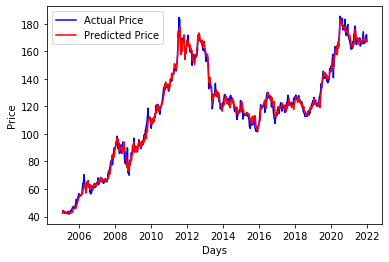

In [91]:
# plot true/pred prices graph
plot_graph(final_df)

In [92]:
final_df.head(10)

,open,high,low,close,adjclose,volume,ticker,adjclose_15,true_adjclose_15
2005-02-10,41.529999,41.840000,41.450001,41.750000,41.750000,7774500,GLD,42.289406,43.380001
2005-02-11,41.889999,42.160000,41.830002,42.080002,42.080002,1896500,GLD,42.646286,43.470001
2005-02-16,42.320000,42.599998,42.200001,42.520000,42.520000,1820400,GLD,43.380287,44.200001
2005-02-23,43.290001,43.549999,43.150002,43.419998,43.419998,1534900,GLD,43.330578,44.310001
2005-03-15,44.230000,44.230000,43.930000,44.060001,44.060001,1254900,GLD,43.707573,42.630001
2005-03-16,44.290001,44.349998,44.200001,44.310001,44.310001,2223300,GLD,43.898426,42.570000
2005-03-22,43.209999,43.220001,42.549999,42.650002,42.650002,2609400,GLD,42.940781,42.900002
2005-03-24,42.509998,42.540001,42.369999,42.389999,42.389999,1466300,GLD,42.825783,42.400002
2005-04-07,42.770000,42.810001,42.529999,42.570000,42.570000,2853000,GLD,42.657501,43.000000
2005-04-08,42.480000,42.709999,42.459999,42.689999,42.689999,1002100,GLD,42.648254,43.349998


In [93]:
final_df.tail(10)

,open,high,low,close,adjclose,volume,ticker,adjclose_15,true_adjclose_15
2021-10-25,168.660004,169.210007,168.529999,168.929993,168.929993,4881300,GLD,169.370728,174.179993
2021-11-08,170.429993,170.699997,170.059998,170.449997,170.449997,4966100,GLD,166.551010,165.500000
2021-11-18,173.960007,174.360001,173.529999,173.940002,173.940002,6252000,GLD,168.690765,166.580002
2021-11-23,167.279999,167.600006,166.529999,167.279999,167.279999,8047800,GLD,167.034805,166.149994
2021-12-15,165.270004,166.399994,163.800003,166.149994,166.149994,14231200,GLD,167.038498,166.990005
2021-12-20,167.880005,168.000000,167.059998,167.089996,167.089996,6973000,GLD,167.573715,170.289993
2021-12-22,167.580002,168.639999,167.110001,168.589996,168.589996,4672900,GLD,168.096985,170.160004
2021-12-28,169.330002,169.649994,168.619995,168.639999,168.639999,4541900,GLD,168.209961,172.080002
2022-01-05,170.619995,170.929993,168.899994,169.059998,169.059998,8715600,GLD,168.291061,167.600006
2022-01-06,167.160004,167.750000,166.860001,166.990005,166.990005,10902700,GLD,167.796967,167.100006


In [95]:
import math
from sklearn.metrics import mean_squared_error

# calculate root mean squared error
rmse = math.sqrt(mean_squared_error(final_df["adjclose_15"], final_df["true_adjclose_15"]))

print('rmse: ',rmse)

rmse:  3.3498163071939566
